In [2]:
from keras.models import model_from_json

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
def load_model(model_name):
    """
    Load model strucutre from json file & weights from h5 file
    
    Input:
        model_name (str): modelName_MonthDAY
    
    Output
        keras Model object
    """
    # load model structure
    with open('./model/%s.json' % model_name, 'r') as json_file:
        json_model = json_file.read()
    model = model_from_json(json_model)
    
    # load model weights
    model.load_weights('./model/%s.h5' % model_name)
    
    return model    

___

# Separate Encoder-decoder Model

In [3]:
# Load encoder
encoder = load_model("encoder_NVIDIA")
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        624       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 36)        0         
_________________________________________________________________
max_

In [4]:
# This is needed to add encoder to computation graph
_X = np.random.randn(1, 64, 64, 1)
_y = encoder.predict(_X)
print(_y)
print(_y.shape)

[[0.02454593 0.02924812 0.         ... 0.02385598 0.11789171 0.04150147]]
(1, 1600)


In [5]:
# Load decoder
decoder = load_model("decoder_NVIDIA_MAY14_MAE_3Dense_ext")
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4800)              0         
_________________________________________________________________
dec_nvi_dense3_1 (Dense)     (None, 500)               2400500   
_________________________________________________________________
dec_nvi_dense3_2 (Dense)     (None, 200)               100200    
_________________________________________________________________
dec_nvi_dense3_3 (Dense)     (None, 25)                5025      
Total params: 2,505,725
Trainable params: 2,505,725
Non-trainable params: 0
_________________________________________________________________


In [7]:
# This is needed to add decoder to computation graph
_X = np.random.randn(1, 3*1600)
_y = decoder.predict(_X)
print(_y)
print(_y.shape)

[[ 0.14338385 -0.45271778  0.03721596 -0.43878222 -0.24771687 -0.06755146
  -0.32807228 -0.6574745  -0.01113721  0.5697291  -0.46894905 -0.15144742
   0.930745    0.61904675  0.38943106  0.6889361  -0.53225505  0.24816085
  -0.32679385 -1.1576396   0.24771456  0.13617569  0.10474768 -0.13571224
  -0.10556354]]
(1, 25)


## Define forward pass through encoder to decoder

In [9]:
def forward_pass(imgs_name_list):
    """
    Pass 3 images through encoder, then decoder to get 25 steering angles
    
    Input:
        imgs_name_list (list): list of name of input images to encoder
        
    Output:
        (np.ndarray) 
    
    """
    
    assert(len(imgs_name_list)==3)
    
    img_path_prefix = '/home/user/Bureau/Dataset/udacity/'
    
    en_X = np.zeros((3, 64, 64, 1))  # initialize input to encoder
    
    de_X = np.zeros((1, 3*1600))  # initialize input to decoder
    
    # fill in en_X
    for i, name in enumerate(imgs_name_list):
        # read image
        img = cv.imread(img_path_prefix + name, 0)

        # resize & reshape image
        img = np.float32(cv.resize(img, (64, 64)))
        if len(img.shape) == 2:
            img = img.reshape((img.shape[0], img.shape[1], 1))

        # add img to input tensor of encoder
        en_X[i, :, :, :] = img 
    
    # calculte forward pass of encoder to get input to decoder
    de_X = encoder.predict(en_X).reshape(1, -1)
    
    return decoder.predict(de_X)
        

___

# Full Hybrid Model

In [11]:
IMAGE_SHAPE = (52, 265, 3)

In [5]:
full_hybrid_model = load_model("seed_style_MAY15_MAE_ext_4Dense_cont")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
def forward_pass_full_hybrid(imgs_name_list):
    
    X = [np.zeros((1,) + IMAGE_SHAPE) for i in range(3)]
    
    img_path_prefix = '/home/user/Bureau/Dataset/udacity/'
    
    # fill in en_X
    for i, name in enumerate(imgs_name_list):
        # read image
        if IMAGE_SHAPE[-1] == 1:
            img = cv.imread(img_path_prefix + name, 0)
        else:
            img = cv.imread(img_path_prefix + name, 1)

        # resize & reshape image
        img = np.float32(cv.resize(img, (IMAGE_SHAPE[1], IMAGE_SHAPE[0]), interpolation=cv.INTER_AREA))
        if len(img.shape) == 2:
            img = img.reshape(IMAGE_SHAPE)

        # add img to input tensor of encoder
        X[i][0, :, :, :] = img
    
    return full_hybrid_model.predict(X)
    

#  Read dataset & prepare test sample

In [7]:
df = pd.read_csv('./data/hybrid_validation.csv')

In [8]:
def getXy(_df, idx):
    """
    Get images file name & associated steering angle from dataframe
    
    Input:
        df (panda.DataFrame): dataframe containing dataset
        idx (int): index of a single row fo df
    
    Output:
        X (list): list of string. Each represents 1 file name
        y (np.ndarray): array of associated steering angles 
    """
    X = _df.iloc[idx].X[2: -2].split("', '")
    y = np.array([float(angle) for angle in _df.iloc[idx].steering_angles[1: -1].split(", ")])
    
    return X, y

# Display prediction and true label

In [9]:
def getPredAndLabel(_df, idx, full_hybrid=False):
    """
    Get the prediction and true value of steering angles
    """
    
    # get image file names to make X & associted steering angle y
    X, y = getXy(_df, idx)
    
    # pass X through encoder-decoder model
    if not full_hybrid:
        y_hat = forward_pass(X)
    else:
        y_hat = forward_pass_full_hybrid(X)
    return y_hat, y
    

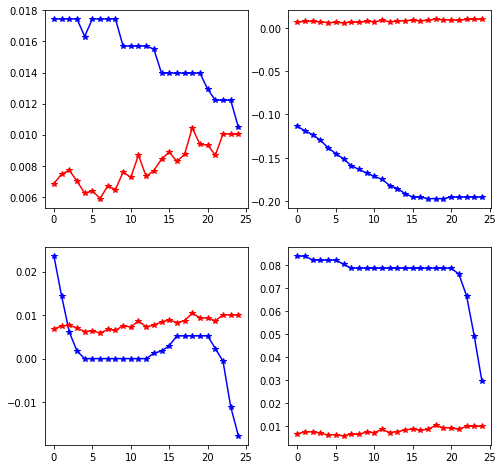

In [12]:
y_hat_list = []
y_list = []

# idx_list = np.random.randint(low=0, high=len(df)-1, size=4)
idx_list = [600,  73, 437, 445]

for idx in idx_list:
    y_hat, y = getPredAndLabel(df, idx, full_hybrid=True)
    # store for plotting
    y_hat_list.append(y_hat)
    y_list.append(y)

# Plot
plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.plot(y_list[0], 'b-*')
plt.plot(y_hat_list[0].squeeze(), 'r-*')

plt.subplot(222)
plt.plot(y_list[1], 'b-*')
plt.plot(y_hat_list[1].squeeze(), 'r-*')

plt.subplot(223)
plt.plot(y_list[2], 'b-*')
plt.plot(y_hat_list[2].squeeze(), 'r-*')

plt.subplot(224)
plt.plot(y_list[3], 'b-*')
plt.plot(y_hat_list[3].squeeze(), 'r-*')

plt.show()

In [14]:
idx_list

array([600,  73, 437, 445])

In [31]:
del decoder